In [318]:
#Bibliotecas 

#bibliotecas básicas
import os
import fnmatch
import math
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#bibliotecas para análise dos dados
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pmd
import numpy_indexed as npi

#biblioteca para exportação de dados
import yfinance as yf

Utilizando a biblioteca yfinance podemos extrair os dados atuais de ações de empresas a partir do Yahoo Finance.

In [366]:
companies = pd.DataFrame(['SPY','NOAH','PDD','YRD','WEI','PFH','PHR','PRU']) #lista das empresas que extrairemos os dados 
                                                                                    #para serem analisados
data = pd.DataFrame() #variável para armazenar os dados

for ii in range(len(companies)):
    aux = yf.Ticker(companies[0][ii])
    aux_data = aux.history(period="1y") #período de 1 ano
    aux_data.reset_index(inplace=True)
    if ii == 0:
        data["Date"] = aux_data.Date 
    data[str(companies[0][ii])] = aux_data.Open #usamos os dados de entrada diários
        
data.rename(columns={'Date':"time"}, inplace = True) #reajuste do index
data.set_index("time")

for i in range(len(companies)): #loop para preencher dados vazios
    data[str(companies[0][i])] = data[str(companies[0][i])].fillna(0)
    data = data.astype({str(companies[0][i]):'float'})
    
data = data.set_index("time")

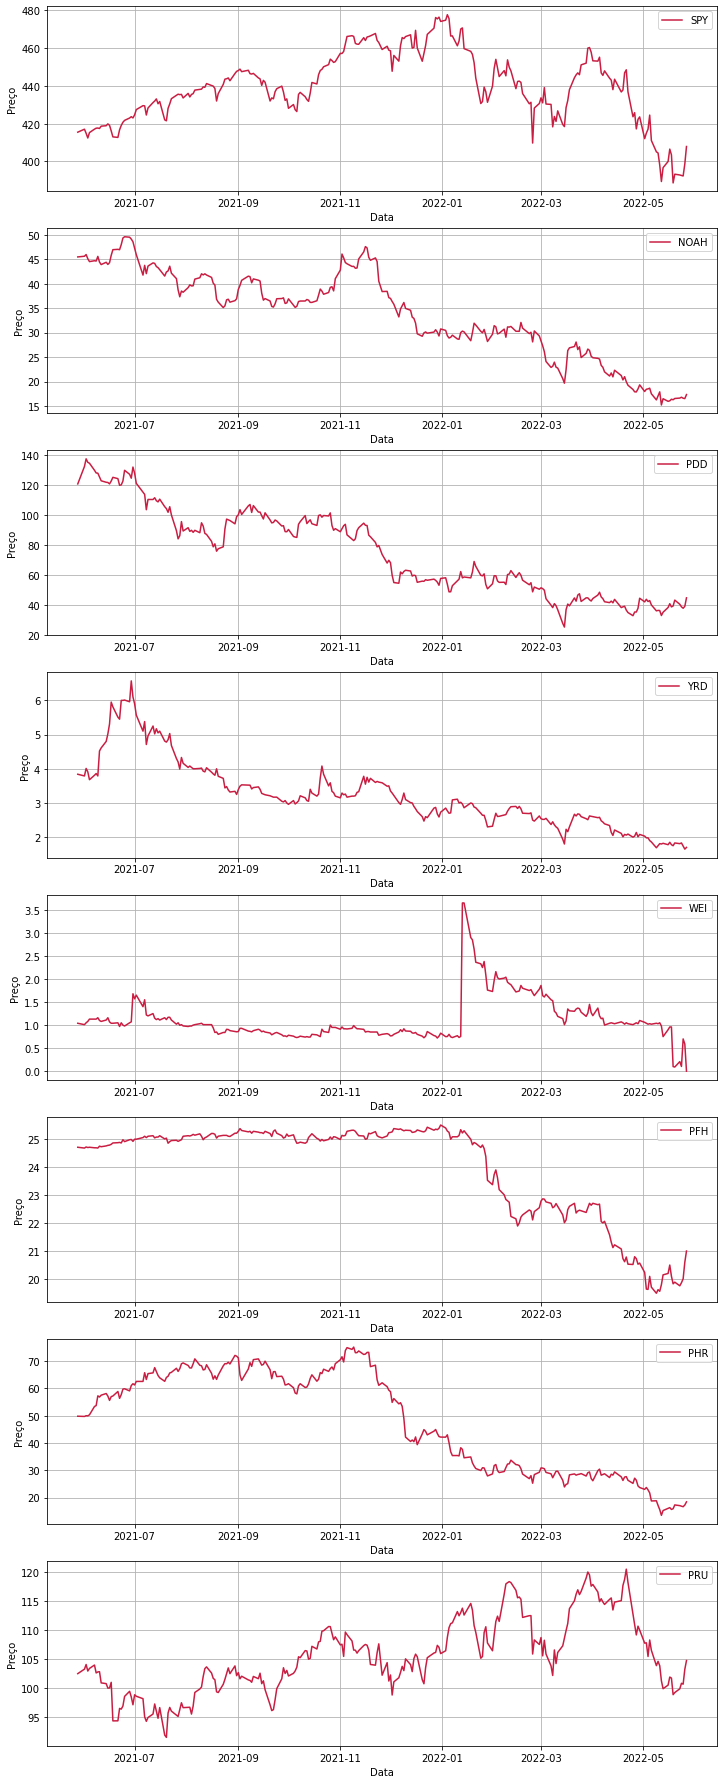

In [328]:
#Gráficos do arquivo "data"

fig, ax = plt.subplots(len(companies),1,figsize=(12,32))

for i in range(len(companies)):
    ax[i].plot(data[str(companies[0][i])], label = str(companies[0][i]),color = '#C91D42') #plot da normalização dos dados para visualização
    ax[i].legend(loc='upper right') 
    ax[i].set_xlabel("Data")
    ax[i].set_ylabel("Preço")
    ax[i].grid()
    ax[i].set_axisbelow(True)

plt.show()

Usando a função "auto_arima" podemos estimar qual a melhor ordem da ARIMA que ajusta os dados, assim podemos agrupa-los segundo a ordem do ajuste.

In [329]:
ordem = pd.DataFrame()
for i in range(len(companies)):
        modelo = pmd.auto_arima(data[str(companies[0][i])], start_p=0, start_d=0, start_q=0, max_p=3, max_d=3, max_q=3,
                        m=12, start_P=0, start_D=0, start_Q=0, trend=None, information_criterion='aic', trace=True, error_action='ignore')
        aux = modelo.get_params().get('order')
        ordem[str(i)] = [aux[0],aux[1],aux[2]]

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1520.904, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=1524.032, Time=0.21 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=1523.960, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=1518.914, Time=0.03 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=1522.720, Time=0.13 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=1522.710, Time=0.16 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=1524.686, Time=0.38 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=1522.307, Time=0.17 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=1522.263, Time=0.28 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=1523.496, Time=0.26 sec

Best model:  ARIMA(0,1,0)(0,0,0)[12]          
Total fit time: 1.875 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=774.844, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=774.755, Time=0.20 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept

 ARIMA(1,1,1)(0,0,1)[12]             : AIC=-205.057, Time=0.31 sec
 ARIMA(1,1,1)(1,0,1)[12]             : AIC=-203.078, Time=0.69 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-202.852, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[12]             : AIC=-204.136, Time=0.19 sec
 ARIMA(2,1,0)(0,0,0)[12]             : AIC=-204.896, Time=0.07 sec
 ARIMA(2,1,2)(0,0,0)[12]             : AIC=-202.128, Time=0.19 sec

Best model:  ARIMA(1,1,1)(0,0,0)[12]          
Total fit time: 8.495 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=999.364, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=999.888, Time=0.11 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=999.962, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=998.648, Time=0.02 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=998.404, Time=0.09 sec
 ARIMA(0,1,0)(2,0,0)[12] intercept   : AIC=1000.362, Time=0.21 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=1000.379, Time=0.19 sec
 ARIMA(0,1,0)

Sabendo os melhores parâmetros para o ajuste dos dados, podemos separá-los por grupos de cada ordem de ARIMA.

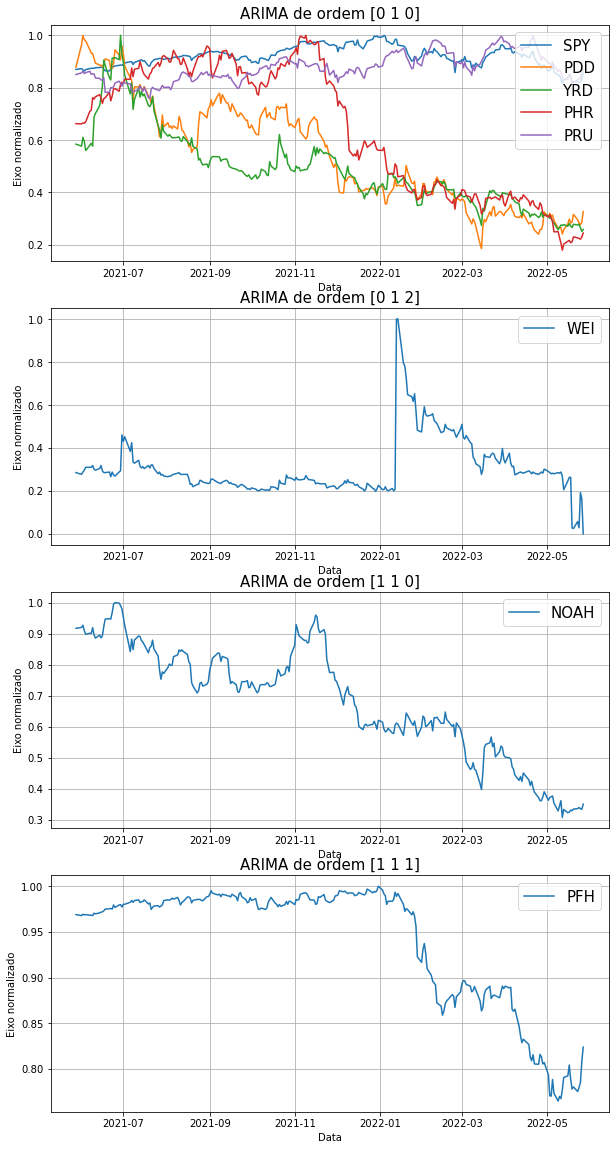

In [330]:
aux = [] 

for ii in range(len(companies)):
    aux.append(ordem[str(ii)].values.tolist()) #armazenar os dados de ordem de cada modelo

ordem_unico = npi.unique(aux) #função para tornar um array com sub-array de maior dimensão unico em elementos

#Por fim separar os grupos de ARIMA e plotar juntos

fig, ax = plt.subplots(len(ordem_unico),1,figsize=(10,20))

for i in range(0,len(companies),1):
    for ii in range(len(ordem_unico)):
        if np.array_equal(np.array(ordem[str(i)]).astype(int), ordem_unico[ii]) == True:
            ax[ii].plot(data[str(companies[0][i])]/data[str(companies[0][i])].max(),label = str(companies[0][i])) #plot da normalização dos dados para visualização
            ax[ii].legend(loc='upper right', fontsize=15)
            ax[ii].set_title("ARIMA de ordem " + str(ordem_unico[ii]), fontsize=15)
            ax[ii].set_xlabel("Data")
            ax[ii].set_ylabel("Eixo normalizado")
            ax[ii].grid()
            ax[ii].set_axisbelow(True)

plt.show()

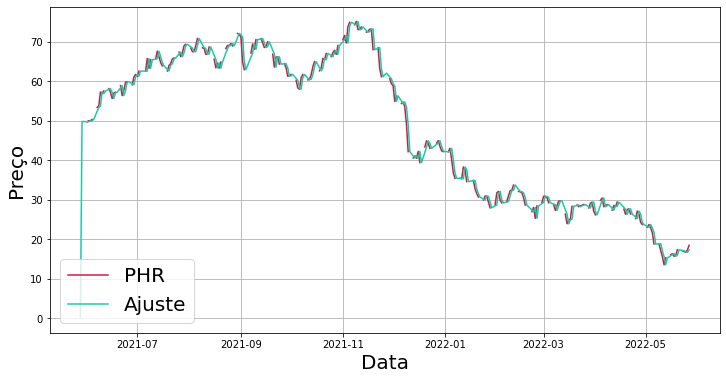

In [411]:
#Olhar o ajuste individual
nomes = (['SPY','NOAH','PDD','YRD','WEI','PFH','PHR','PRU'])

cc = 'PHR' #string com o nome da empresa desejada

data_range = pd.date_range(start=data.index.unique()[0], end=data.index.unique()[-1], freq="D") #completar os dias incompletos com a interpolação dos dados
aux_data = data.reindex(data_range)
data_new = aux_data.interpolate()

#ajuste do ARIMA
modelo_teste = ARIMA(endog=data_new[cc],order=np.array(ordem[str(nomes.index(cc))]).astype(int), freq="D").fit()

fig, ax = plt.subplots(1,1,figsize=(12,6))

ax.plot(aux_data[cc], label = cc,color = '#C91D42') 
ax.plot(modelo_teste.predict(),label = 'Ajuste',color = '#1DC9A4' )
ax.legend(loc='lower left', fontsize=20) 
ax.set_xlabel("Data", fontsize=20)
ax.set_ylabel("Preço", fontsize=20)
ax.grid()
ax.set_axisbelow(True)

plt.show()